In [527]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn import model_selection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.model_selection import GridSearchCV,train_test_split,RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report,f1_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, Lasso
from sklearn.externals import joblib
from sklearn.svm import SVC, LinearSVC
import xgboost as xgb
import gensim
from contractions import CONTRACTION_MAP
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('words')
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\gaurav.singh.rawal\AppData\Roaming\nltk_data.
[nltk_data]     ..
[nltk_data]   Package words is already up-to-date!


In [528]:
train_data=pd.read_csv(r"C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\train.csv")
test_data=pd.read_csv(r"C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\test.csv")

In [577]:
test_data.shape

(1304, 14)

In [530]:
temp = train_data.groupby('sentiment_class').count()['original_text'].reset_index().sort_values(by='original_text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment_class,original_text
1,0,1701
0,-1,769
2,1,765


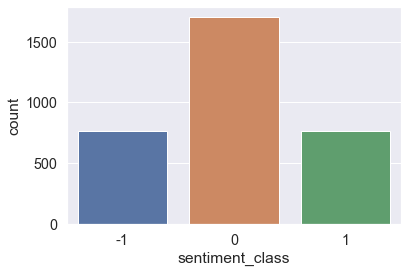

In [531]:
sns.countplot(x='sentiment_class',data=train_data)

In [532]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3235 entries, 0 to 3234
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3235 non-null   float64
 1   original_text    3235 non-null   object 
 2   lang             3231 non-null   object 
 3   retweet_count    3231 non-null   object 
 4   original_author  3235 non-null   object 
 5   sentiment_class  3235 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 151.8+ KB


In [533]:
train_data['retweet_count']=train_data['retweet_count'].astype(str)
test_data['retweet_count']=test_data['retweet_count'].astype(str)

In [534]:
train_data["retweet_count"]= train_data["retweet_count"].str.replace(r"[a-zA-Z$@#&*!''-/]",'')
train_data["retweet_count"]= train_data["retweet_count"].replace(r'^\s*$', np.nan, regex=True)

In [535]:
test_data["retweet_count"]= test_data["retweet_count"].str.replace(r"[a-zA-Z$@#&*!''-/]",'')
test_data["retweet_count"]= test_data["retweet_count"].replace(r'^\s*$', np.nan, regex=True)

In [536]:
train_data['retweet_count']=pd.to_numeric(train_data['retweet_count'])
test_data['retweet_count']=pd.to_numeric(test_data['retweet_count'])

In [537]:
train_data.loc[train_data["retweet_count"]<0,'retweet_count']=0
train_data.loc[train_data["retweet_count"].isna(),'retweet_count']=0
test_data.loc[test_data["retweet_count"]<0,'retweet_count']=0
test_data.loc[test_data["retweet_count"].isna(),'retweet_count']=0
train_data.loc[train_data["retweet_count"]>100,'retweet_count']=100
test_data.loc[test_data["retweet_count"]>100,'retweet_count']=100

In [538]:
train_data["retweet_count"]=train_data["retweet_count"].astype(int)
test_data["retweet_count"]=test_data["retweet_count"].astype(int)

In [539]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [540]:
train_data['original_text']=train_data['original_text'].apply(expand_contractions)
test_data['original_text']=test_data['original_text'].apply(expand_contractions)

In [541]:
train_data.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,Happy #MothersDay to all you amazing mothers out there! I know it is hard not being able to see your mothers today but it is on all of us to do what we can to protect the most vulnerable members of our society. #BeatCoronaVirus pic.twitter.com/va4nFjFQ5B,en,0,BeenXXPired,0
1,1.245759e+18,Happy Mothers Day Mum - I am sorry I cannot be there to bring you Mothers day flowers & a cwtch - honestly at this point I would walk on hot coals to be able to. But I will be there with bells on as soon as I can be. Love you lots xxx (p.s we need more photos!) https:// photos.app.goo.gl/M3vXBLrsCzD4TE bY7 …,en,1,FestiveFeeling,0
2,1.246087e+18,"Happy mothers day To all This doing a mothers days work. Today been quiet but Had time to reflect. Dog walk, finish a jigsaw do the garden, learn few more guitar chords, drunk some strawberry gin and tonic and watch Lee evens on DVD. My favourite place to visit. #isolate pic.twitter.com/GZ0xVvF6f9",en,0,KrisAllenSak,-1
3,1.244803e+18,Happy mothers day to this beautiful woman...royalty soothes you mummy jeremy and emerald and more #PrayForRoksie #UltimateLoveNG pic.twitter.com/oeetI22Pvv,en,0,Queenuchee,0
4,1.244876e+18,"Remembering the 3 most amazing ladies who made me who I am! My late grandmother iris, mum carol and great grandmother Ethel. Missed but never forgotten! Happy mothers day to all those great mums out there! Love sent to all xxxx pic.twitter.com/xZZZdEybjE",en,0,brittan17446794,-1


In [542]:
## Number of words in the original_text ##
train_data["num_words"] = train_data["original_text"].apply(lambda x: len(str(x).split()))
test_data["num_words"] = test_data["original_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the original_text ##
train_data["num_unique_words"] = train_data["original_text"].apply(lambda x: len(set(str(x).split())))
test_data["num_unique_words"] = test_data["original_text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the original_text ##
train_data["num_chars"] = train_data["original_text"].apply(lambda x: len(str(x)))
test_data["num_chars"] = test_data["original_text"].apply(lambda x: len(str(x)))

## Number of stopwords in the original_text ##
train_data["num_stopwords"] = train_data["original_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_data["num_stopwords"] = test_data["original_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the original_text ##
train_data["num_punctuations"] =train_data['original_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_data["num_punctuations"] =test_data['original_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the original_text ##
train_data["num_words_upper"] = train_data["original_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_data["num_words_upper"] = test_data["original_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the original_text ##
train_data["num_words_title"] = train_data["original_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_data["num_words_title"] = test_data["original_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the original_text ##
train_data["mean_word_len"] = train_data["original_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data["mean_word_len"] = test_data["original_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [543]:
'''cols_to_drop = ['id','original_text','sentiment_class','lang','original_author']
train_y = train_data.sentiment_class
train_X = train_data.drop(cols_to_drop, axis=1)
test_X = test_data.drop(['id','original_text','lang','original_author'], axis=1)'''

"cols_to_drop = ['id','original_text','sentiment_class','lang','original_author']\ntrain_y = train_data.sentiment_class\ntrain_X = train_data.drop(cols_to_drop, axis=1)\ntest_X = test_data.drop(['id','original_text','lang','original_author'], axis=1)"

In [544]:
'''def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model'''

'def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):\n    param = {}\n    param[\'objective\'] = \'multi:softprob\'\n    param[\'eta\'] = 0.1\n    param[\'max_depth\'] = 3\n    param[\'num_class\'] = 3\n    param[\'eval_metric\'] = "mlogloss"\n    param[\'min_child_weight\'] = child\n    param[\'subsample\'] = 0.8\n    param[\'colsample_bytree\'] = colsample\n    param[\'seed\'] = seed_val\n    num_rounds = 2000\n\n    plst = list(param.items())\n    xgtrain = xgb.DMatrix(train_X, label=train_y)\n\n    if test_y is not None:\n        xgtest = xgb.DMatrix(test_X, label=test_y)\n        watchlist = [ (xgtrain,\'train\'), (xgtest, \'test\') ]\n        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)\n    else:\n        xgtest = xgb.DMatrix(test_X)\n        model = xgb.train(plst, xgtrain, num_rounds)\n\n    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)\n    if tes

In [545]:
'''kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_data.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(100*(f1_score(val_y,pred_val_y,average='weighted')))
    break
print("cv scores : ", cv_scores)'''

'kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)\ncv_scores = []\npred_full_test = 0\npred_train = np.zeros([train_data.shape[0], 3])\nfor dev_index, val_index in kf.split(train_X):\n    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]\n    dev_y, val_y = train_y[dev_index], train_y[val_index]\n    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)\n    pred_full_test = pred_full_test + pred_test_y\n    pred_train[val_index,:] = pred_val_y\n    cv_scores.append(100*(f1_score(val_y,pred_val_y,average=\'weighted\')))\n    break\nprint("cv scores : ", cv_scores)'

In [546]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no","never"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords)
        return clean_X

In [547]:
ct = CleanText()
train_data['original_text'] = ct.fit_transform(train_data.original_text)
test_data['original_text']=ct.fit_transform(test_data.original_text)

In [548]:
train_data['original_text'] = train_data['original_text'].astype(str)
test_data['original_text'] = test_data['original_text'].astype(str)

In [549]:
words = set(nltk.corpus.words.words())

def clean_text(raw_text):
    return " ".join(w for w in nltk.wordpunct_tokenize(raw_text) \
     if w.lower() in words or not w.isalpha())


In [550]:
train_data['original_text'] = train_data['original_text'].apply(clean_text)
test_data['original_text'] = test_data['original_text'].apply(clean_text)

In [551]:
'''from langdetect import detect
def clean_lang(df):
    #df.loc[((detect(df['original_text'])=='en') and df['lang']!='en'),'lang'] = 'en'
    for row_df in df:
        if ((detect(row_df[1])=='en') and row_df[2]!='en'):
            row_df[2]=""+'en'
            
    return df '''   

'from langdetect import detect\ndef clean_lang(df):\n    #df.loc[((detect(df[\'original_text\'])==\'en\') and df[\'lang\']!=\'en\'),\'lang\'] = \'en\'\n    for row_df in df:\n        if ((detect(row_df[1])==\'en\') and row_df[2]!=\'en\'):\n            row_df[2]=""+\'en\'\n            \n    return df '

In [552]:
train_data=train_data[train_data['lang']=='en']
test_data=test_data[test_data['lang']=='en']

In [553]:
porter = PorterStemmer()
def stem_text(input_text):
    words = input_text.split()
    return " ".join([porter.stem(word) for word in words])


In [554]:
train_data['original_text'] = train_data['original_text'].apply(stem_text)
test_data['original_text'] = test_data['original_text'].apply(stem_text)

In [555]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(input_text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(input_text)]

In [556]:
train_data['original_text'] = train_data['original_text'].apply(lemmatize_text).astype(str)
test_data['original_text'] = test_data['original_text'].apply(lemmatize_text).astype(str)

In [557]:
def clean_text(text_df):
    text_df["clean_text"]= text_df["original_text"].str.replace("mum", "mother", case = False)
    text_df["clean_text"]= text_df["clean_text"].str.replace("mom", "mother", case = False)
    text_df["clean_text"]= text_df["clean_text"].str.replace("mothersday","mother day") 
    text_df["clean_text"]= text_df["clean_text"].str.replace("httpswww","") 
    text_df["clean_text"]= text_df["clean_text"].str.replace("http","") 
    text_df["clean_text"]= text_df["clean_text"].str.replace("u","") 
    return text_df

In [558]:
train_df=clean_text(train_data)
test_df=clean_text(test_data)

In [559]:
test_df.shape

(1304, 14)

In [560]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self

In [561]:
train_df=train_df.reset_index()
test_df=test_df.reset_index()

In [562]:
print(test_df.index)

RangeIndex(start=0, stop=1304, step=1)


In [563]:
### Fit transform the tfidf vectorizer ###
tfidf = TfidfVectorizer(norm=None,token_pattern=r"(?u)\b\w+\b", stop_words=None, sublinear_tf=True, max_df=0.5, analyzer='word', 
           ngram_range=(1,2))
tfidf_score = tfidf.fit_transform(train_df['clean_text'])
train_tfidf = pd.DataFrame(tfidf_score.toarray(),columns=tfidf.get_feature_names())
train_df = pd.concat([train_df,train_tfidf], axis = 1)

In [564]:
print(train_df.shape)

(2994, 24071)


In [565]:
train_df.head()

,index,id,original_text,lang,retweet_count,original_author,sentiment_class,num_words,num_unique_words,num_chars,...,yov love,yr,yr cri,yr old,zero,zero wonder,zodiac,zodiac sign,zoom,zoom pic
0,0,1.245025e+18,"['happi', 'amaz', 'know', 'hard', 'not', 'abl', 'see', 'today', 'u', 'protect', 'vulner', 'societi', 'pic', 'twitter']",en,0,BeenXXPired,0,45,37,254,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.245759e+18,"['happi', 'day', 'mum', 'sorri', 'cannot', 'bring', 'day', 'honestli', 'point', 'would', 'walk', 'hot', 'abl', 'soon', 'love', 'lot', 'need', 'goo']",en,1,FestiveFeeling,0,63,50,309,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.246087e+18,"['happi', 'day', 'day', 'work', 'today', 'quiet', 'time', 'reflect', 'dog', 'walk', 'finish', 'garden', 'learn', 'guitar', 'drunk', 'strawberri', 'gin', 'tonic', 'watch', 'lee', 'even', 'place', 'visit', 'isol', 'pic', 'twitter']",en,0,KrisAllenSak,-1,51,47,298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1.244803e+18,"['happi', 'day', 'beauti', 'woman', 'royalti', 'mummi', 'emerald', 'pic', 'twitter']",en,0,Queenuchee,0,18,17,155,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1.244876e+18,"['amaz', 'ladi', 'made', 'late', 'grandmoth', 'iri', 'mum', 'carol', 'great', 'grandmoth', 'ethel', 'never', 'forgotten', 'happi', 'day', 'great', 'love', 'sent', 'pic', 'twitter']",en,0,brittan17446794,-1,42,37,254,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [566]:
test_tfidf_score = tfidf.transform(test_df['clean_text'])
test_tfidf = pd.DataFrame(test_tfidf_score.toarray(),columns=tfidf.get_feature_names())
test_df = pd.concat([test_df,test_tfidf], axis = 1)

In [567]:
print(test_tfidf.index)

RangeIndex(start=0, stop=1304, step=1)


In [568]:
test_df.head(20)

,index,id,original_text,lang,retweet_count,original_author,num_words,num_unique_words,num_chars,num_stopwords,...,yov love,yr,yr cri,yr old,zero,zero wonder,zodiac,zodiac sign,zoom,zoom pic
0,0,1.246628e+18,"['yeah', 'potato', 'old', 'mean', 'threw', 'bag', 'toilet', 'happi', 'day', 'made', 'breakfast', 'time', 'thought', 'cool', 'draw', 'nake', 'ladi', 'dachshund', 'overhead', 'projector', 'psycholog', 'class']",en,0,LToddWood,56,46,275,24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.245898e+18,"['happi', 'day', 'step', 'cover', 'parent', 'twitter']",en,0,iiarushii,22,22,192,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.244717e+18,"['love', 'peopl', 'howev', 'awok', 'saw', 'woke', 'immedi', 'happi', 'day', 'across', 'way', 'god', 'bless', 'love', 'share', 'make']",en,0,andreaanderegg,44,35,237,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1.245730e+18,"['happi', 'st', 'birthday', 'happi', 'mother', '’', 's', 'day', 'mum', 'can', '’', 't', 'see', 'today', 'keep', 'safe', 'shame', 'mani', 'advic', 'pic', 'twitter']",en,1,TheBookTweeters,30,28,203,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1.244636e+18,"['happi', 'day', 'wonder', 'world', 'live', 'present', 'alway', 'reli', 'mother', 'rock', 'whatev', 'life']",en,0,andreaanderegg,39,34,200,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,1.244048e+18,"['happi', 'day', 'thank', 'support', 'mother', 'daughter', 'spend', 'rest', 'unburden', 'made', 'everi', 'day', 'feel', 'like', 'could', 'last', 'lent', 'faith', 'pic', 'twitter']",en,0,iamxander5,41,39,271,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,1.243919e+18,"['happi', 'ruth', 'happi', 'day', 'love', 'peac', 'beauti', 'day', 'beauti', 'friend', 'stay', 'super', 'safe', 'love', 'alway', 'pic', 'twitter']",en,0,HoneyDewListApp,25,23,165,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,1.246245e+18,"['happi', 'day', 'amaz', 'care', 'love', 'much', 'give', 'best', 'thank', 'god', 'twitter', 'st']",en,0,LToddWood,35,32,211,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,1.246139e+18,"['happi', 'day', 'mum', 'mani', 'could', 'not', 'visit', 'phone', 'good', 'day', 'better', 'time', 'pic', 'twitter']",en,0,ShowBuzzDaily,33,31,180,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,1.244255e+18,"['happi', 'mother', 'afternoon', 'bed', 'new', 'book', 'later', 'bliss']",en,2,AngelsFreak7,22,21,210,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [569]:
test_df_id=test_df.id
test_df=test_df.drop(['id','original_text','lang','original_author','clean_text','index'],axis=1)

In [570]:
y = train_df.sentiment_class
X = train_df.drop(['id','original_text','sentiment_class','lang','original_author','clean_text','index'],axis=1)

In [571]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

In [572]:
best_scores={}
best_models={}
mnb = MultinomialNB(alpha=0.1)
bnb = BernoulliNB()
linsvc = LinearSVC()
logreg = LogisticRegression()
sgd=SGDClassifier()
svc=SVC()
gbm=GradientBoostingClassifier()

In [573]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.5, 0.75, 1.0),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2),(1,3),(2,2)),
    'features__pipe__vect__min_df': (1,2,3,4,5)
}
# Parameter grid settings for MultinomialNB
'''parameters_mnb = {
    'alpha': (0.01,0.1,0.25,0.5,0.75),
    'fit_prior' : (True,False)
}'''
# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2'),
    'clf__fit_intercept': (True,False)
}
parameters_sgd = {
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l1', 'l2','elasticnet'),
    'clf__max_iter': (10, 25, 50, 75, 100)
}
parameters_svc = {'clf__kernel': ['linear', 'rbf'],
                    'clf__gamma':[0.1,1,10],
                    'clf__C':[0.1,1,0.001,0.0001]
                 }
parameters_gbm = {'clf__loss':['deviance','exponential'],
         'clf__learning_rate': [0.05,0.1],
         'clf__max_depth':[5,10,20],
         'clf__n_estimators': [10,25,50]
        }
parameters_xgb = {'clf__learning_rate':[0.01,0.1],
         'clf__n_estimators':[50,100,500],
         'clf__max_depth':[5,10,15,20],
        }

In [574]:
from sklearn.model_selection import KFold, cross_val_score
def grid_vect(model, X_train, X_test, y_train, y_test, parameters_clf=None):
    #pipeline = Pipeline([('features', features),('clf', clf)])
    
    # Join the parameters dictionaries together
    if parameters_clf is not None:
        parameters = dict()
        parameters.update(parameters_clf)
        # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
        grid_search_model = RandomizedSearchCV(model, parameters, n_jobs=-1, scoring='f1_weighted',verbose=1, cv=5,random_state=42)
        print("Performing grid search...")
        grid_search_model.fit(X_train, y_train)
        print("Best CV score: %0.3f" % grid_search_model.best_score_)
        print("Best parameters set:")
        best_parameters = grid_search_model.best_estimator_.get_params()
        for param_name in sorted(parameters.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
        print("Test score with best_estimator_: %0.3f" % grid_search_model.best_estimator_.score(X_test, y_test))
        return grid_search_model
    else:
        scores = cross_val_score(model, X_train, y_train, cv=5,scoring='precision_macro')
        print("Test score with cross validation are: ")
        print(scores)
        print("Test score with MNB: %0.3f" % (100*(model.fit(X_train, y_train).score(X_test, y_test))))
        model.fit(X_train,y_train)
        return model
        


In [575]:
X_train.head()

,retweet_count,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,2060,...,yov love,yr,yr cri,yr old,zero,zero wonder,zodiac,zodiac sign,zoom,zoom pic
2912,3,57,53,275,25,4,2,7,3.842105,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2241,0,45,37,280,19,23,1,9,5.244444,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
257,0,44,40,293,18,15,0,6,5.681818,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
454,32,43,41,274,17,18,2,8,5.395349,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
775,0,19,18,171,4,9,0,7,8.052632,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [576]:
test_df.head()

,retweet_count,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,2060,...,yov love,yr,yr cri,yr old,zero,zero wonder,zodiac,zodiac sign,zoom,zoom pic
0,0,56,46,275,24,10,7,10,3.928571,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,22,22,192,6,13,0,3,7.772727,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,44,35,237,20,9,3,9,4.409091,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,30,28,203,9,10,1,5,5.800000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,39,34,200,20,2,0,3,4.153846,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [525]:
best_mnb_countvect = grid_vect(mnb,X_train,X_test,y_train,y_test,None)
prediction_mnb=best_mnb_countvect.predict(X_test)
mnb_score=100*(f1_score(y_test,prediction_mnb,average='weighted'))
train_pred1=best_mnb_countvect.predict(X_train)
test_pred1=best_mnb_countvect.predict(X_test)
print("\nAccuracy score of Multinomial naive bayes algorithm -----> " + str(mnb_score))

Test score with cross validation are: 
[0.39442026 0.36307185 0.36887035 0.3213841  0.34555627]
Test score with MNB: 30.885

Accuracy score of Multinomial naive bayes algorithm -----> 31.569974532150358


In [ ]:
best_bnb_countvect = grid_vect(bnb,X_train, X_test,model_features,parameters_mnb,
                               parameters_countvect=parameters_vect,parameters_tfidf=parameters_tfidf)
prediction_bnb=best_bnb_countvect.predict(X_test)
bnb_score=100*(f1_score(y_test,prediction_bnb,average='weighted'))
best_scores['mnb_countvect']=best_bnb_countvect.best_score_
best_models['mnb_countvect']=best_bnb_countvect
train_pred1=best_bnb_countvect.predict(X_train)
test_pred1=best_bnb_countvect.predict(X_test)
print("\nAccuracy score of Multinomial naive bayes algorithm -----> " + str(bnb_score))

In [526]:
#best_mnb_model=mnb.set_params(**best_mnb_countvect.best_params_)
best_mnb_countvect.fit(X,y)
test_predictions=best_mnb_countvect.predict(test_df)
prediction_df = pd.DataFrame(columns=['sentiment_class'],data=test_predictions)
prediction_df = pd.concat([test_df_id,prediction_df],axis=1)
prediction_df.to_csv(r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\predictions.csv',index=False,encoding = 'utf-8')

In [ ]:
# LogisticRegression
best_losso_countvect = grid_vect(linsvc,X_train, X_test,model_features,parameters_linsvc,
                                 parameters_countvect=parameters_vect,parameters_tfidf=parameters_tfidf)
prediction_losso = best_losso_countvect.predict(X_test)
losso_score=100*(f1_score(y_test,prediction_losso,average='weighted'))
best_scores['losso_countvect']=best_losso_countvect.best_score_
best_models['losso_countvect']=best_losso_countvect
train_pred2=best_losso_countvect.predict(X_train)
test_pred2=best_losso_countvect.predict(X_test)
print("\nAccuracy score of Lasso algorithm -----> " + str(losso_score))

In [ ]:
# SGD
best_sgd_countvect = grid_vect(sgd, parameters_sgd, X_train, X_test,model_features, parameters_text=parameters_vect)
prediction_sgd = best_sgd_countvect.predict(X_test)
sgd_score=100*(f1_score(y_test,prediction_sgd,average='weighted'))
best_scores['sgd_countvect']=best_sgd_countvect.best_score_
best_models['sgd_countvect']=best_sgd_countvect
train_pred3=best_sgd_countvect.predict(X_train)
test_pred3=best_sgd_countvect.predict(X_test)
print("\nAccuracy score of SGD algorithm -----> " + str(sgd_score))

In [ ]:
# SVC
best_svc_countvect = grid_vect(svc, parameters_svc, X_train, X_test,model_features, parameters_text=parameters_vect)
prediction_svc = best_svc_countvect.predict(X_test)
svc_score=100*(f1_score(y_test,prediction_svc,average='weighted'))
best_scores['svc_countvect']=best_svc_countvect.best_score_
best_models['svc_countvect']=best_svc_countvect
train_pred4=best_svc_countvect.predict(X_train)
test_pred4=best_svc_countvect.predict(X_test)
print("\nAccuracy score of SVC algorithm -----> " + str(svc_score))


In [ ]:
# GBC
best_gbm_countvect = grid_vect(gbm, parameters_gbm, X_train, X_test,model_features, parameters_text=parameters_vect)
prediction_gbm = best_gbm_countvect.predict(X_test)
gbm_score=100*(f1_score(y_test,prediction_gbm,average='weighted'))
best_scores['gbm_countvect']=best_gbm_countvect.best_score_
best_models['gbm_countvect']=best_gbm_countvect
train_pred5=best_gbm_countvect.predict(X_train)
test_pred5=best_gbm_countvect.predict(X_test)
print("\nAccuracy score of gbc algorithm -----> " + str(gbm_score))

In [ ]:
from sklearn.ensemble import VotingClassifier
countvect_classifier= VotingClassifier(estimators=[('mnb', best_models['mnb_countvect']), ('lr', best_models['logreg_countvect']),
                         ('sgd', best_models['sgd_countvect']), ('svc', best_models['svc_countvect']),
                         ('gbm', best_models['gbm_countvect'])],voting='hard')
countvect_classifier.fit(X_train,y_train)
countvect_classifier_predictions=countvect_classifier.predict(X_test)
countvect_classifier_predictions_score=100*(f1_score(y_test,countvect_classifier_predictions,average='weighted'))
print("\nAccuracy score of Voting Classifier algorithm -----> " + str(countvect_classifier_predictions_score))

In [ ]:
df_train = pd.concat([pd.DataFrame(train_pred1),pd.DataFrame(train_pred2),
                      pd.DataFrame(train_pred3),pd.DataFrame(train_pred4),pd.DataFrame(train_pred5)], axis=1)
df_test = pd.concat([pd.DataFrame(test_pred1),pd.DataFrame(test_pred2),pd.DataFrame(test_pred3)
                     ,pd.DataFrame(test_pred4),pd.DataFrame(test_pred5)], axis=1)


In [ ]:
df_train.columns=['mnb','lr','sgd','svc','gbm']
df_test.columns=['mnb','lr','sgd','svc','gbm']

In [ ]:
df_train.shape

In [ ]:
from xgboost import XGBClassifier

def hyperparameter_tuner(model,X_train,y_train,hp_list):
    
    hp_perf=[]
    hp_model=RandomizedSearchCV(model,param_distributions=hp_list,n_iter=10,n_jobs=-1, scoring='f1_weighted',verbose=1, cv=5)
    hp_model.fit(X_train,y_train)
    best_hp_model=hp_model.best_estimator_
    best_param=hp_model.best_params_
    best_score=hp_model.best_score_  
   
    return best_hp_model,best_param,best_score

xgb=XGBClassifier({
    'objective': 'multi:softprob',
    'eta': 0.1,
    'max_depth': 3,
    'silent' :1,
    'num_class' : 3,
    'eval_metric' : "mlogloss",
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.3,
    'seed':17,
    'num_rounds':2000,
})
xgb.fit(df_train,y_train)

#best_model,best_params,best_score=hyperparameter_tuner(xgb,df_train,y_train,parameters_xgb)

prediction_xgb = xgb.predict(df_test)
xgb_score=100*(f1_score(y_test,prediction_xgb,average='weighted'))
print("\nAccuracy score of XGB stacking algorithm -----> " + str(xgb_score))

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
model = BaggingClassifier(RandomForestClassifier(max_depth=25,min_samples_leaf=2,n_estimators=25))
model.fit(df_train,y_train)
bagging_pred = model.predict(df_test)
bagging_score=100*(f1_score(y_test,bagging_pred,average='weighted'))
print("\nAccuracy score of Random Forest Bagging algorithm -----> " + str(bagging_score))